In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
from scipy.special import digamma, logsumexp, gamma
from numpy.linalg.linalg import inv, det

import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import clear_output

import time
import random

from pprint import pprint


In [2]:
plt.rcParams['figure.figsize'] = [15, 8]
np.set_printoptions(precision=3)


In [3]:
np.random.seed(1243)

# Dimensiones
D = 2

# Numero de datos
N = 200

# Cantidad de gausianas
N_GAUS = 4

K = 2



## Funcion generadora de muestras

In [4]:
def generar_muestras(n_gausianas, n_muestras, D):
    # Primero creamos cada una de las 4 gausianas
    means = []
    covs = []
    
    
    datos_gausianas = {"medias": [], "covs": [], "pis": []}


    for i in range(n_gausianas):
        means.append(np.random.uniform(0, 10*n_gausianas/4, (D, )))
        A = sp.random.rand(D,D)
        A = np.random.uniform(-1.2, 1.2, (D, D))
        B = np.dot(A,A.transpose())
        L = np.identity(D)
        
        covs.append(B + L*0.15)
        
    means = np.array(means)
    covs = np.array(covs)
    
    datos_gausianas['medias'] = means
    datos_gausianas['covs'] = covs
    
    gausianas = []

    for i in range(n_gausianas):
        gausianas.append(multivariate_normal(mean = means[i], cov = covs[i]))
        
    samples_separadas = [[] for i in range(n_gausianas)]
    
    # Generar pesos de gausianas aleatoriamente
    totales = []
    pesos = []
    for i in range(n_gausianas):
        peso = random.randint(5, 100)
        pesos.append(peso)
        totales += [i for _ in range(peso)]
        
    total_peso = np.sum(pesos)
    datos_gausianas['pis'] = [peso/total_peso for peso in pesos]
    
    for _ in range(n_muestras):
        n_gausiana = random.choice(totales)
        gausiana = gausianas[n_gausiana]
        
        sample = gausiana.rvs()
        samples_separadas[n_gausiana].append(sample)
    

    samples_separadas = np.array(samples_separadas)

    samples = np.concatenate(samples_separadas)
    
    
    return samples, datos_gausianas


In [5]:
def graficar_muestras(samples=[]):
    plt.subplot(1, 2, 2)

    plt.scatter(samples[:, 0], samples[:, 1])

    plt.subplot(1, 2, 1)
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.title('Muestras generadas')

    plt.subplot(1, 2, 2)
    plt.title('Histograma de muestras generadas')
    plt.hist2d(samples[:, 0], samples[:, 1], bins = 40)

    plt.show()

c:\users\marti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


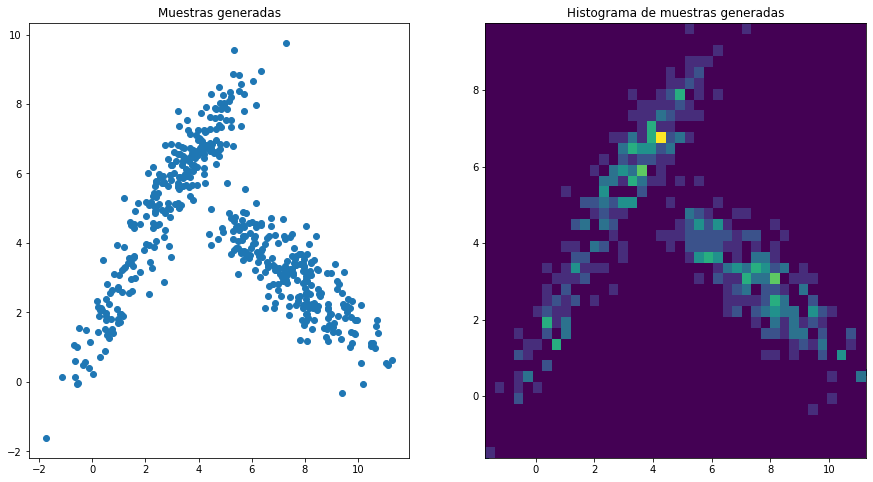

{'covs': array([[[ 2.52 , -1.625],
        [-1.625,  1.484]],

       [[ 1.559,  1.394],
        [ 1.394,  1.588]],

       [[ 0.887,  1.079],
        [ 1.079,  1.767]]]),
 'medias': array([[7.425, 3.115],
       [3.681, 6.352],
       [1.11 , 2.589]]),
 'pis': [0.4900990099009901, 0.35148514851485146, 0.15841584158415842]}


In [6]:
samples, datos_gausianas = generar_muestras(3, 500, 2)
graficar_muestras(samples)
pprint(datos_gausianas)


# Definicion de ecuaciones necesarias

## Ecuacion 1

$$ln\;\hat\pi_k ≡ E[ln \;\pi_k] = ψ(\alpha_k) − ψ(\hat\alpha)$$

Donde $\pi_k$ es el parametro del peso de cada gausiana que se esta estimando

In [7]:
def funcion_1(alphas):
    """
    alphas es el vector de alpha_k, uno por gausiana
    retorna log_pi
    """
    return digamma(alphas) - digamma(np.sum(alphas))
    
    

## Ecuacion 2

$$ln\;Λ_k ≡ E[ln |Λ_k| ] = 
\sum_{i=1}^D
ψ(
\frac{νk + 1 − i)}{2}
)
+ D * ln\; 2 + ln \;|W_k|$$

In [8]:
def funcion_2(D, Vs, Ws, K):
    """
    K --> Numero de gausianas estimadas
    D --> Numero de dimensiones
    vs --> vector de v_k por gausiana
    Ws --> lista de matrices de dimension 
    retorna log_precisiones
    """
    log_precisiones = np.zeros((K, ))
    
    
    for k in range(K):
        determinante = np.linalg.det(Ws[k])

        if determinante > 1e-30: 
            log_det = np.log(determinante)
        else:
            log_det = 0.0
        log_precisiones[k] = sum([digamma((Vs[k]+1-i) / 2.) for i in range(D)]) + D*np.log(2) + log_det
        
    return np.array(log_precisiones)

### Ecuacion 3

$$E[(x_n − µ_k)^T Λ_k (x_n − µ_k)]= Dβ^{−1}_k + ν_k(x_n − m_k)^T W_k (x_n − m_k)$$

In [9]:
def funcion_3(D, K, Vs, betas, Ws, medias, samples):
    """
    D --> numero de dimensiones
    vs --> vector de v_k por gausiana
    betas --> vector de b_k por gausiana
    Ws --> Vector de matrices W_k (cada una es de dimension DxD)
    medias --> vector de medias_k por gausiana (Dx1) (mK negrita)
    samples --> 
    
    retorna E_mu_precision --> vector de vectores (1 para cada K), cada vector interior es un escalar para cada sample
    """
    N = len(samples)

    E_mu_precision_2 = np.zeros((K, N))

    for k in range(K):
        prim = D/betas[k]

        aux = (samples - medias[k]).reshape((N, D, 1))
        mult_1 = np.matmul((samples - medias[k]).reshape((N, D)), Ws[k])
        mult_2 = np.einsum("ij,ijk->ik", mult_1, aux).reshape((N))
        

        E_mu_precision_2[k] = prim + mult_2*Vs[k]
    
    return E_mu_precision_2

### Funcion 4

$$ln\; ρ_{nk} = E[ln \;π_k] + 0.5*E[ln\; |Λ_k| ] − 0.5*D*ln\;(2π) − 0.5*E[µ_k,Λ_k(x_n − µ_k)^T Λ_k(x_n − µ_k)]$$

In [10]:
def funcion_4(log_pis, log_precisiones, K, D, E_mu_precision, N):
    """
    E_mu_precision --> resultado de funcion 3
    
    retorna log_rho_n_k --> Vector tamano k (uno para cada k), con un vector de tamano n (uno para cada sample)
    """
    
    aux = log_pis + 0.5*log_precisiones - 0.5*D*np.log(2*np.pi)
    total2 = np.repeat(aux, N).reshape((K, N)) - 0.5*E_mu_precision
    return np.array(total2)



### Funcion 5


$$log\; r_{nk} = log \rho_{nk} - log\;\sum e^{log\;\rho_{nk}}$$

In [11]:
def funcion_5(log_rho_n_k, K, N):
    """
    Recibe input de funcion 4
    retorna log_r_n_k --> 
    """
    log_sum_exp = np.tile(logsumexp(log_rho_n_k, axis = 0), K).reshape((K, N))
    return log_rho_n_k - log_sum_exp



### Ecuacion 6

$$
N_k = 
\sum_{n=1}^N
r_{nk}
$$

In [12]:
def funcion_6(r_n_k, K):
    """
    Recibe de entrada el input de la funcion 5
    
    retorna Ns --> Nk para cada K
    """
    return np.nan_to_num(np.sum(r_n_k, axis = 1))

### Ecuacion 7
$$
x_k = \frac{1}{N_k}
\sum_{n=1}^N
r_{nk}*x_n
$$

In [13]:
def funcion_7(r_n_k, samples, Ns, K, D, N):
    """
    retorna x_barras --> x_barra_k por cada k
    """
    
    aux = np.tile(samples, [K, 1]).reshape((K, N, D))
    
    A = np.matmul(r_n_k, aux)

    final = np.zeros((K, D))
    for i, a in enumerate(A):
        final[i] = (a/Ns[i])[i]
        
    return np.array(final)

### Ecuacion 8
$$
x_k = \frac{1}{N_k}
\sum_{n=1}^N
r_{nk}*x_n
(x_n − x_k)(x_n − x_k)^T
$$

In [14]:
def funcion_8(Ns, r_n_k, x_barras, samples, D, K, N):
    """
    retorna Ss --> Un S_k por k, que contiene 1 matriz de dimension DxD
    """

    final = []
    for k in range(K):
        aux = (samples - x_barras[k]).reshape((N, D, 1))
        aux_t = (samples - x_barras[k]).reshape((N, 1, D))
        matrices = aux@aux_t
        
        final.append(np.einsum("i,ijk->jk", r_n_k[k], matrices)/Ns[k])
            
    final = np.array(final)
    return final

### Ecuacion 8.2
$$
β_k = β_0 + N_k
$$

In [15]:
def funcion_8_2(K, Ns, beta_0):
    """
    retorna betas
    """
    
    return Ns + beta_0

### Ecuacion 9
$$
m_k = 
\frac{1}{β_k}
(β_0*m_0 + N_k*x_k)
$$

In [16]:
def funcion_9(K, betas, beta_0, media_0, Ns, x_barras):
    """
    retorna medias --> mk
    """
    nueva_medias = []
    media_0 = np.copy(media_0)
    for k in range(K):
        nueva_medias.append((media_0*beta_0 + Ns[k]*x_barras[k])/betas[k])
        
    return np.array(nueva_medias)


### Ecuacion 10

$$
W^{−1}_k = W_0^{−1} + N_k*S_k + \frac{β_0*N_k}{β_0 + N_k}*(x_k − m_0)(x_k − m_0)^T
$$

In [17]:
def funcion_10(W0, Ns, Ss, beta_0, x_barras, media_0, K, D):
    """retorna Ws"""
    datos = []
    W0_inv = np.matrix(W0).I
    for k in range(K):
        seg = Ns[k]*Ss[k]
        ter = beta_0*Ns[k]/(beta_0 + Ns[k])
        aux = np.reshape(x_barras[k] - media_0, (D, 1))
        ter *= np.matmul(aux, aux.T)
        
        
        invers = np.matrix(W0_inv + seg + ter)
            
        invers = np.nan_to_num(invers)
        try:
            datos.append(invers.I)
        except: 
            datos.append(invers)
    return np.array(datos)
    
    

### Ecuacion 11 y 12

$$
ν_k = ν_0 + N_k
$$

$$α_k = α_0 + N_k$$

In [18]:
def funcion_11(v_0, Ns):
    return Ns + v_0

def funcion_12(alpha_0, Ns):
    return Ns + alpha_0

### Ecuacion 13
$$E[π_k] = 
\frac{α_k + N_k}{K*α_0 + N}
$$

In [19]:
def funcion_13(alphas, Ns, K, alpha_0, N):
    total = []
    for k in range(K):
        total.append((alphas[k] + Ns[k])/(K*alpha_0 + N))
        
    return np.array(total)

## Ecuaciones extras para el calculo de lower bound

### $C(\alpha)$

In [20]:
def c_alpha(alphas):
    
    return 1
    
    # No me se las propiedades de la funcion gamma para dividir
    total = np.sum(alphas)
    arriba = gamma(total)
    abajo = np.sum(gamma(alphas))
    gamma(alphas)

    return arriba/abajo
    

### $ B(W, v)$

In [21]:
def B_w_v(W, v, D):
    
    # A veces funcionaba y otras tiraba nan, preferi descartar los terminos con este
    return 1
    det = np.linalg.det(W)
    prim = np.power(det, -v/2)
    
    pita = 1
    for d in range(D):
        pita*=gamma((v + 1 - d + 1)/2)
    segunda = np.power(2,v*D/2)*np.power(np.pi, D*(D-1)/4)
    
    
    return prim/segunda
    

### $E[ln |Λ|]$


In [22]:
def E_ln_precision(D, v, W):
    ter = np.log(np.linalg.det(W))
    seg = D*np.log(2)
    suma = 0
    for i in range(D):
        suma += digamma((v + 1 - i + 1)/2)
        
    return suma + seg + ter
    

### $H[Λ]$

In [23]:
def H_precision(K, N, D, W, v):
    primera = -np.log(B_w_v(W, v, D))
    segunda = (-(v - D - 1)/2)*E_ln_precision(D, v, W)
    
    
    return primera + segunda + v*D/2

## Ecuaciones lower bound

A continuacion se definen todas las ecuaciones necesarias para calcular el ELBO

### 10.71



In [24]:
def ELBO_primera(K, N, D, Ns, log_precisiones, betas, Vs, Ss, Ws, x_barras, medias):
    total = 0
    
    for k in range(K):
        
        trace = np.trace(np.matmul(Ss[k], Ws[k]))
        parte_1 = log_precisiones[k] - D/betas[k] - Vs[k]*trace
        
        aux = x_barras[k] - medias[k]
        aux_2 = np.matmul(np.matmul(aux.T, Ws[k]),aux )

        parte_2 = -Vs[k]*aux_2 - D*np.log(2*np.pi)
        
        total += Ns[k]*(parte_1 + parte_2)
        
    return total/2

### 10.72

In [25]:
def ELBO_segunda(K, N, D, r_n_k, log_pis):
    
    total = 0
    for k in range(K):
        total += np.sum(r_n_k[k]*log_pis[k])

    return total

### 10.73

In [26]:
def ELBO_tercera(K, N, D, alpha_0, log_pis):
    
    return np.log(1) + (alpha_0 - 1) + np.sum(log_pis)

    

### 10.74

In [27]:
def ELBO_cuarta(K, N, D, beta_0, log_precisiones, betas, Vs, medias, media_0, Ws, W_0, v_0):
    
    total = 0
    sumatoria = 0
    for k in range(K):
        primera = D*np.log(beta_0/(2*np.pi)) + log_precisiones[k] - (D*beta_0)/betas[k]
        aux = medias[k] - media_0
        mult = np.matmul(np.matmul(aux.T, Ws[k]), aux)
        segunda = beta_0*Vs[k]*mult
        
        sumatoria += primera - segunda
        
    sumatoria = sumatoria/2
    
    
    segunda = K*np.log(B_w_v(W_0, v_0, D))
    tercera = np.sum(log_precisiones)*(v_0 - D - 1)/2
    cuarta = 0
    for k in range(K):
        cuarta += Vs[k]*np.trace(np.matmul(np.matrix(W_0).I, Ws[k]))
    cuarta = cuarta/2
    
    
    return sumatoria + segunda + tercera + cuarta

### 10.75

In [28]:
def ELBO_quinta(K, N, D, r_n_k):
    total = 0
    log_r_n_k = np.log(r_n_k)
    for k in range(K):
        total += np.dot(r_n_k[k], log_r_n_k[k])
        
    if np.isnan(total):
        return 0
    else:
        return total
        

### 10.76

In [29]:
def ELBO_sexta(K, N, D, alphas, log_pis):
    parte_1 = np.log(c_alpha(alphas))
    total = 0
    for k in range(K):
        total += (alphas[k] - 1)*log_pis[k]
    return total + parte_1

### 10.77

In [30]:
def ELBO_septima(K, N, D, log_precisiones, betas, Ws, Vs):
    total = 0
    
    for k in range(K):
        total += 0.5*log_precisiones[k] + 0.5*D*np.log(betas[k]/(2*np.pi)) - D/2 - H_precision(K, N, D, Ws[k], Vs[k])
    
    
    
    return total

In [31]:
def crear_gausianas_adivinadas(K, medias, Ss, log_pis):
    """
    Metodo que retorna un arreglo de K gausianas segun datos dados
    """
    gausianas_totales = []
    medias = np.nan_to_num(medias)
    Ss = np.nan_to_num(Ss)

    pis = np.exp(log_pis)
    for k in range(K):
        try:
            gausianas_totales.append(multivariate_normal(mean = medias[k], cov=Ss[k]).pdf)
        except:
            gausianas_totales.append(0)
            pass
    return gausianas_totales



## Funcion iterativa

Los pasos que sigue mi funcion son mas o menos los siguientes:
1. Definir los priors y un valor inicial para el ELBO
2. Calcular Ns --> Cuantos datos son parte de una gausiana k en esta iteracion. Si ese numero es 0, esa gausiana se elimina
3. Liego viene el equivalente al M-step --> Maximizar los valores dado los anteriores. Aqui se calculan los parametros de las gausianas en esta iteracion
$$V_k $$
$$\bar x$$
$$S_k \text{ Corresponde a la matriz de covarianza de la gausiana K }$$
$$\beta_k$$
$$m_k \text{ Corresponde al vector de medias de la gausiana K}$$
$$W_s$$


4. Despues viene el E-step, donde se actualizan el resto de los parametros
5. Se calcula el ELBO usando las formulas del libro
6. Si se tiene que D=2, y la visualizacion esta activa, se muestra el avance de las gausianas
7. Cuando se termina el algoritmo, se muestran las estadisticas finales, estas se pueden comparar con ```datos_gausianas```, que viene de la funcion generadora de muestras

In [32]:
# El orden de ejecucion de los pasos fue ibtenido de https://github.com/jamesmcinerney/vbmm/blob/master/varmix.py

def adivinar_gausianas(samples,K, max_iter = 100, visualizacion=False):
    
    min_x = min(samples[:, 0])
    max_x = max(samples[:, 0])

    min_y = min(samples[:, 1])
    max_y = max(samples[:, 1])


    X_LINS, Y_LINS = np.mgrid[min_x:max_x:0.1, min_y:max_y:0.11]

    POS = np.empty(X_LINS.shape + (2,))
    POS[:, :, 0] = X_LINS; POS[:, :, 1] = Y_LINS
    

    # Priors
    N = len(samples)   
    D = samples[0].shape[0]
    
    alpha_0 = 0.1
    beta_0 = 0.5
    media_0 = np.array([0 for _ in range(D)])
    v_0 = 2
    W0 = np.identity(D)*100
    
    
    r_n_k = np.array([np.random.dirichlet(np.ones(K)) for _ in range(N)]).T
    log_r_n_k = np.log(r_n_k)
    
    ELBO =  np.inf
    
    for n_iter in range(max_iter):
        #M-like-step
        Ns = funcion_6(r_n_k, K)
        
        # Sacar gausianas que no aportan
        indices_malos = np.where(Ns == 0)[0]
        if len(indices_malos) > 0:
            Ns = np.delete(Ns, indices_malos)
            log_pis = np.delete(log_pis, indices_malos)
            log_precisiones = np.delete(log_precisiones, indices_malos)
            E_mu_precision = np.delete(E_mu_precision, indices_malos, axis = 0)
            log_rho_n_k = np.delete(log_rho_n_k, indices_malos, axis = 0)
            log_r_n_k = np.delete(log_r_n_k, indices_malos, axis = 0)
            r_n_k = np.delete(r_n_k, indices_malos, axis= 0)
            x_barras = np.delete(x_barras, indices_malos, axis = 0)
            Ss = np.delete(Ss, indices_malos, axis = 0)
            medias = np.delete(medias, indices_malos, axis=0)
            Ws = np.delete(Ws, indices_malos, axis=0)
            Vs = np.delete(Vs, indices_malos)
            alphas = np.delete(alphas, indices_malos)
            K -= len(indices_malos)

        # M-step
            
        Vs = funcion_11(v_0 ,Ns)

        x_barras = funcion_7(r_n_k, samples, Ns, K, D, N)
        
        Ss = funcion_8(Ns, r_n_k, x_barras, samples, D, K, N)
        
        betas = funcion_8_2(K, Ns, beta_0)
        
        medias = funcion_9(K, betas, beta_0, media_0, Ns, x_barras)

        Ws = funcion_10(W0, Ns, Ss, beta_0, x_barras, media_0, K, D)

        #E--step
        E_mu_precision = funcion_3(D, K, Vs, betas, Ws, medias, samples)
        
        log_precisiones = funcion_2(D, Vs, Ws, K)
        
        alphas = funcion_12(alpha_0, Ns)
        log_pis = funcion_1(alphas)

        log_rho_n_k = funcion_4(log_pis, log_precisiones, K, D, E_mu_precision, N)
        log_r_n_k = funcion_5(log_rho_n_k, K, N)
        
        r_n_k = np.exp(log_r_n_k)
        r_n_k = np.nan_to_num(r_n_k)
        
        a = ELBO_primera(K, N, D, Ns, log_precisiones, betas, Vs, Ss, Ws, x_barras, medias)
        b = ELBO_segunda(K, N, D, r_n_k, log_pis)
        c = ELBO_tercera(K, N, D, alpha_0, log_pis)
        d = ELBO_cuarta(K, N, D, beta_0, log_precisiones, betas, Vs, medias, media_0, Ws, W0, v_0)
        e = ELBO_quinta(K, N, D, r_n_k)
        f = ELBO_sexta(K, N, D, alphas, log_pis)
        g = ELBO_septima(K, N, D, log_precisiones, betas, Ws, Vs)

        
        ELBO_nuevo = a + b + c + d - e - f - g

        if np.abs(ELBO - ELBO_nuevo) <= 1e-3:
            break
        
        ELBO = ELBO_nuevo
        
        if D == 2 and visualizacion:
            gausianas_adivinadas = crear_gausianas_adivinadas(K, x_barras, Ss, log_pis)
            plt.scatter(samples[:, 0], samples[:, 1])
            pis = np.exp(log_pis)
            for i, gausiana in enumerate(gausianas_adivinadas):
                if gausiana != 0:
                    plt.contour(X_LINS, Y_LINS, pis[i]*gausiana(POS), levels=10)
            plt.title(f'Iteracion {n_iter}')
            plt.suptitle(f'Gausianas restantes: {K}\nELBO: {ELBO}')
            plt.show()
            clear_output(wait=True)
            
        else:
            print(f"Iteracion: {n_iter}")
            print(f"ELBO: {ELBO}")
            clear_output(wait=True)
    
    if D == 2:
        gausianas_adivinadas = crear_gausianas_adivinadas(K, x_barras, Ss, log_pis)
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.8)
        pis = np.exp(log_pis)
        for i, gausiana in enumerate(gausianas_adivinadas):
            if gausiana != 0:
                plt.contour(X_LINS, Y_LINS, pis[i]*gausiana(POS), levels=20)
        plt.title("Gausianas estimadas ajustadas a los datos")
        plt.show()

            
    # Estadisticas
    print(f"Iteraciones realizadas: {n_iter}")
    print(f"Se estima que hay {K} gausianas, con los siguientes parametros")
    pis = np.exp(log_pis)
    for k in range(K):
        print(f"Gausiana {k}:")
        print(f"\tPeso: {pis[k]}")
        print(f"\tMedia: {x_barras[k]}")
        print(f"\tMatriz de covarianza:")
        for fila in Ss[k]:
            print(f"\t\t{fila}")
        
        

        

c:\users\marti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


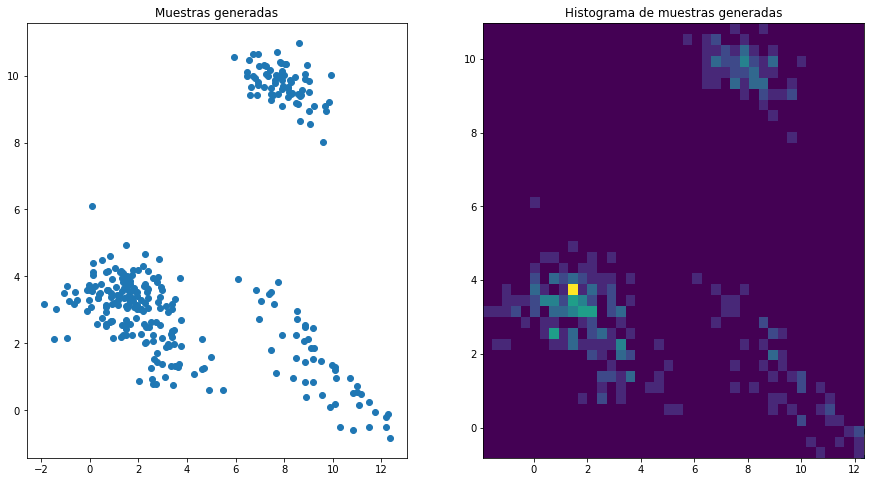

In [43]:
samples, datos_gausianas = generar_muestras(n_gausianas = 4, n_muestras = 300, D = 2)

graficar_muestras( samples)


c:\users\marti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:123: UserWarning: No contour levels were found within the data range.


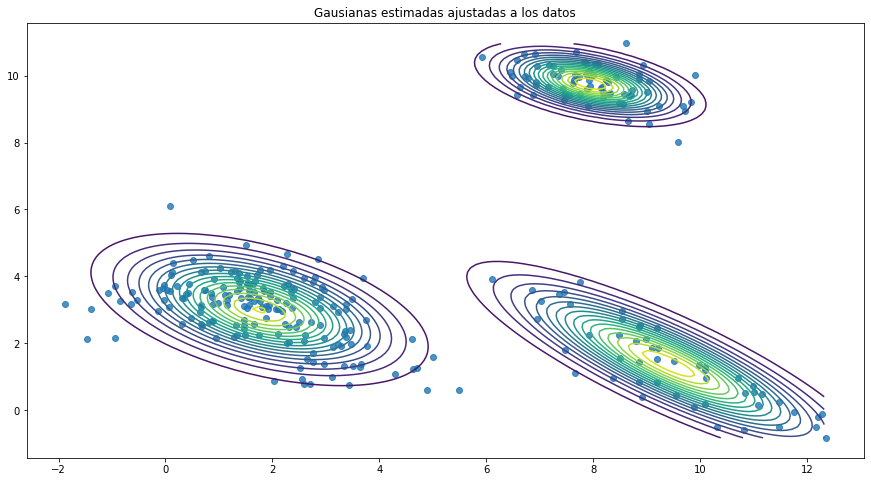

Iteraciones realizadas: 37
Se estima que hay 6 gausianas, con los siguientes parametros
Gausiana 0:
	Peso: 0.5912824657438643
	Media: [1.76 3.01]
	Matriz de covarianza:
		[ 1.752 -0.616]
		[-0.616  0.909]
Gausiana 1:
	Peso: 9.902721203797252e-08
	Media: [2.032 0.886]
	Matriz de covarianza:
		[ 2.022e-25 -8.580e-26]
		[-8.580e-26  3.641e-26]
Gausiana 2:
	Peso: 9.902721203797252e-08
	Media: [2.032 0.886]
	Matriz de covarianza:
		[ 2.022e-25 -8.580e-26]
		[-8.580e-26  3.641e-26]
Gausiana 3:
	Peso: 0.235256774100839
	Media: [7.947 9.757]
	Matriz de covarianza:
		[ 0.812 -0.235]
		[-0.235  0.283]
Gausiana 4:
	Peso: 0.16913389445029348
	Media: [9.409 1.397]
	Matriz de covarianza:
		[ 2.522 -1.737]
		[-1.737  1.649]
Gausiana 5:
	Peso: 9.902721203797252e-08
	Media: [2.032 0.886]
	Matriz de covarianza:
		[ 2.022e-25 -8.580e-26]
		[-8.580e-26  3.641e-26]


In [44]:
adivinar_gausianas(samples = samples, K= 6, max_iter=2000, visualizacion=True)

In [603]:
pprint(datos_gausianas)

{'covs': array([[[ 1.089, -0.158],
        [-0.158,  0.272]],

       [[ 1.723, -1.412],
        [-1.412,  1.428]],

       [[ 0.28 , -0.156],
        [-0.156,  0.345]],

       [[ 0.719,  0.864],
        [ 0.864,  1.519]]]),
 'medias': array([[1.425, 6.005],
       [9.931, 3.406],
       [9.548, 5.932],
       [7.095, 1.488]]),
 'pis': [0.26063829787234044,
         0.031914893617021274,
         0.43617021276595747,
         0.2712765957446808]}


## Conclusiones

En general logre buenos resultados, con que casi siempre las gausianas terminan donde deben.
